In [21]:
import numpy as np
import time
import polars as pl
import random

def dist(A, B, GramMatrix):
    return (
        np.diag(np.matmul(
            np.matmul(A, GramMatrix), 
            A.T)) +
        np.diag(np.matmul(
            np.matmul(B.T, GramMatrix), 
            B)).reshape(-1, 1) - 
        2 * (np.matmul(
            np.matmul(B.T, GramMatrix), 
            A.T))) 

In [22]:
def performance_test(n: int, k: int, m: int, iterations: int):
    A = np.random.rand(m, n)
    B = np.random.rand(n, k)
    
    # Gram matrix must be symmetric
    GramMatrix = np.random.rand(n, n)
    GramMatrix = (GramMatrix + GramMatrix.T) * 0.5
    
    assert A.shape[0] == m and B.shape[1] == k
    
    naive_time = 0
    new_time = 0
    for it in range(iterations):
        result1 = np.zeros((k, m))
        
        point0 = time.time()
        
        for j in range(m):
            for i in range(k):
                result1[i, j] = np.dot(np.dot(A[j] - B[:,i].T, GramMatrix), A[j].T - B[:,i]).item()
                
        point1 = time.time()   
          
        result2 = dist(A, B, GramMatrix)
        
        point2 = time.time()
        
        assert np.allclose(result1, result2)
        
        naive_time += (point1 - point0)
        new_time += (point2 - point1)
   
    return naive_time, new_time, iterations
        

In [23]:
print(performance_test(3, 4, 6, 10000))

(1.2199058532714844, 0.2180790901184082, 10000)


In [ ]:
df1 = pl.DataFrame(schema=['n', 'k', 'm', 'naive_version_time', 'matrix_version_time', 'iterations_count'])
df1 = df1.cast({
    "n": pl.Int64,   
    "k" : pl.Int64,
    "m" : pl.Int64,
    "naive_version_time": pl.Float64,  
    "matrix_version_time": pl.Float64,
    "iterations_count" :  pl.Int64   
})


launches_count = 500
iterations = 10

k = random.randint(1, 1000)
m = random.randint(1, 1000)

import random
for n in range(1, launches_count):
    naive_version_time, matrix_version_time, iterations_count = performance_test(n, k, m, iterations)
    print(f'{n=}', f'{k=}', f'{m=}', f'{naive_version_time=}', f'{matrix_version_time=}', f'{iterations_count=}', sep="\n", end="\n\n")
    df1 = df1.vstack(pl.DataFrame({\
        'n' : n,
        'k' : k,
        'm' : m,
        'naive_version_time' : naive_version_time, 
        'matrix_version_time' : matrix_version_time, 
        'iterations_count' : iterations_count}))

df1.write_csv("different_n.csv")

In [ ]:
df2 = pl.DataFrame(schema=['n', 'k', 'm', 'naive_version_time', 'matrix_version_time', 'iterations_count'])
df2 = df2.cast({
    "n": pl.Int64,   
    "k" : pl.Int64,
    "m" : pl.Int64,
    "naive_version_time": pl.Float64,  
    "matrix_version_time": pl.Float64,
    "iterations_count" :  pl.Int64   
})    
 
launches_count = 1000
iterations = 10 
 
n = random.randint(1, 100)

file_path = "same_n.csv"
df2.write_csv(file_path)

for i in range(1, launches_count + 1):
    k = random.randint(1, 1000)
    m = random.randint(1, 1000)
    naive_version_time, matrix_version_time, iterations_count = performance_test(n, k, m, iterations)
    print(f'{i=}', f'{n=}', f'{k=}', f'{m=}', f'{naive_version_time=}', f'{matrix_version_time=}', f'{iterations_count=}', sep="\n")
    df2 = df2.vstack(pl.DataFrame({\
        'n' : n,
        'k' : k,
        'm' : m,
        'naive_version_time' : naive_version_time, 
        'matrix_version_time' : matrix_version_time, 
        'iterations_count' : iterations_count}))
    
    
    
    if i % 10 == 0:
        df2.write_csv(file_path)
            
    
    
    


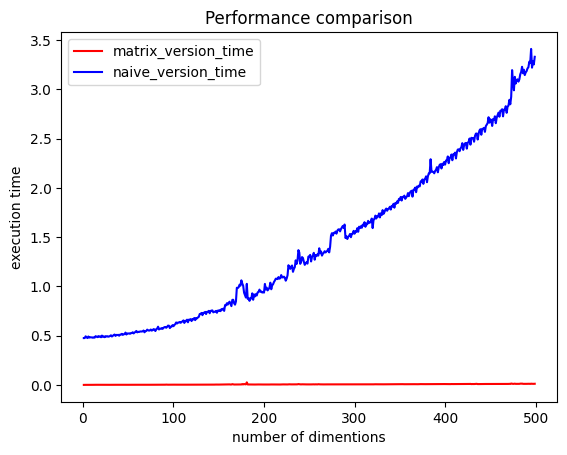

In [24]:
import hvplot.pandas

df = pl.read_csv("different_n.csv")
df = df.to_pandas()
df["matrix_version_time"] = df["matrix_version_time"]/df['iterations_count']
df["naive_version_time"] = df["naive_version_time"]/df['iterations_count']
df.hvplot.line("n", ["naive_version_time", "matrix_version_time"])

import matplotlib.pyplot as plt

plt.plot(df["n"], df["matrix_version_time"], label="matrix_version_time", color="red")
plt.plot(df["n"], df["naive_version_time"], label="naive_version_time", color="blue")
plt.legend()
plt.xlabel('number of dimentions')
plt.ylabel('execution time')
plt.title('Performance comparison')
plt.show()

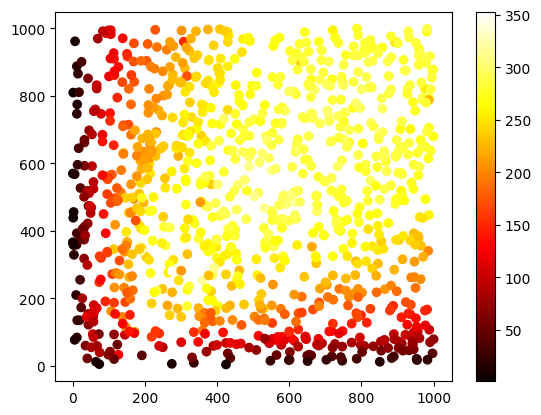

In [25]:
import hvplot.pandas
import matplotlib.pyplot as plt

df = pl.read_csv("same_n.csv")

plt.scatter(df["k"], df["m"], c=df["naive_version_time"]/df["matrix_version_time"], cmap='hot')
plt.colorbar()
plt.show()